# Task 1:  Discriminative Models – CNN vs. ViT Inductive Biases: 

### Importing libraries


Importing the necessary libraries for the task.

In [121]:
import os
import torch
import numpy as np
import torchvision
import pathlib
from torchvision.transforms import v2
import matplotlib.pyplot as plt
import tqdm
from torchmetrics import ConfusionMatrix, Precision, Recall, F1Score
from torch import nn
from torchinfo import summary
import seaborn as sns
from sklearn.metrics import classification_report
from torchvision.models import resnet50, ResNet50_Weights, vit_b_16, ViT_B_16_Weights


### Creating Dataset Directory

Creating the directories in which the STL-10 data will be stored, and best model-params will be stored.

In [122]:
root = pathlib.Path("./data")
params_dir = pathlib.Path("./models")

if not os.path.exists(root):
    os.mkdir(root)

if not os.path.exists(params_dir):
    os.mkdir(params_dir)

### Downloading Image Preprocessing Transforms

We use the default transforms associated with ResNet50_Weights.IMAGENET1K_V1 and ViT_B_16_Weights.IMAGENET1K_V1. The documentation for these weights and their corresponding transforms can be found here https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html, https://docs.pytorch.org/vision/0.19/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16.

Additionally, the mean and standard deviation used for image normalization are stored for later use during image visualization. Notably, both ViT-B-16 and ResNet-50 share the same default transforms when using the specified weights. This allows the same dataset to be used for fine-tuning both models.

In [123]:

weights = ResNet50_Weights.IMAGENET1K_V1
transform = weights.transforms()  

mean=torch.tensor([0.485, 0.456, 0.406])
std=torch.tensor([0.229, 0.224, 0.225])

### Downloading the STL-10 Dataset and visualizing data

The STL-10 dataset is an image dataset with few labelled examples, and is used for unsupervised pre-training. The dimensions of the images are 96 by 96, with three channels. A more detailed overview of the data can be found here https://cs.stanford.edu/~acoates/stl10/.

In [125]:
dataset = torchvision.datasets.STL10(root, transform=transform, download=True)
trainset, testset = torch.utils.data.random_split(dataset, [0.5, 0.5])
classes = dataset.classes
print("Classes: ", classes)

Classes:  ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


In [126]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(trainset, batch_size, shuffle=True, num_workers=os.cpu_count())
test_loader = torch.utils.data.DataLoader(testset, batch_size, shuffle=False, num_workers=os.cpu_count())

In [127]:
def show_images(ims: torch.tensor, labels: torch.tensor):
    fig, axes = plt.subplots(1, len(ims))
    fig.subplots_adjust(wspace=0, hspace=0)
    titles= [classes[i] for i in labels]
  
    for im, title, ax in zip(ims, titles, axes):
        im = im.permute(1, 2, 0)
        im = im*std+mean
        ax.imshow(im) 
        ax.axis('off')
        ax.set_title(title)

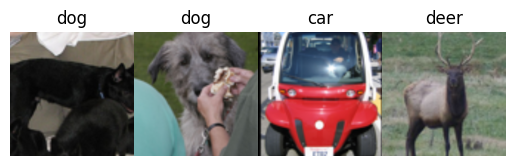

In [128]:
n_samples = 4
X, Y = next(iter(train_loader))
ims, labels = X[:n_samples], Y[:n_samples] 

show_images(ims, labels)

### Training, Testing and Evaluation Functions

Here we define the functions which will be used to train, test and evaluate the models. In addition, The provided functions are device-agnostic.

In [129]:
def metrics(y_preds: torch.tensor, y: torch.tensor, num_classes: int,):
    y_preds, y = y_preds.cpu(), y.cpu()
    confmat = ConfusionMatrix('multiclass', num_classes=num_classes)
    return {"confmat" : confmat(y_preds, y),"classification_report":classification_report(y, y_preds.argmax(axis=1))}

def train_step(train_loader: torch.utils.data.DataLoader, model: torch.nn.Module, optimizer: torch.optim.Optimizer, loss_fn: torch.nn.Module, device: torch.device):
    model.to(device), model.train()
    train_loss, num_correct = 0, 0

    for X,Y in train_loader:
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        preds = model(X)
        loss = loss_fn(preds,Y)
        num_correct += sum(preds.argmax(axis=1)==Y).item()
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()

    train_loss/=len(train_loader)
    acc = num_correct/(len(train_loader.dataset))
    print(f"\nTrain loss: {train_loss:.5f} |  Train acc: {acc*100:.2f} %\n", flush=True)
    return train_loss, acc

def test_step(test_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module, device: torch.device):
    model.to(device), model.eval()
    test_loss, num_correct = 0, 0

    with torch.inference_mode():
        for X,Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            test_loss += loss_fn(preds,Y).item()
            num_correct += sum(preds.argmax(axis=1)==Y).item()

    test_loss /= len(test_loader)
    acc = num_correct/len(test_loader.dataset)
    print(f"Test loss: {test_loss:.5f} | Test acc: {acc*100:.2f} %\n", flush=True)
    return test_loss, acc

def train(train_loader: torch.utils.data.DataLoader, test_loader: torch.utils.data.DataLoader, epochs: int, optimizer: torch.optim.Optimizer, model: torch.nn.Module, loss_fn: torch.nn.Module, device: torch.device):
    model.to(device)
    train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []
   
    for epoch in tqdm.trange(epochs):
        print(f"epoch: {epoch+1}")
        train_loss, train_acc = train_step(train_loader, model, optimizer, loss_fn, device)
        test_loss, test_acc = test_step(test_loader, model, loss_fn, device)
        train_losses.append(train_loss), train_accuracies.append(train_acc)
        test_losses.append(test_loss), test_accuracies.append(test_acc)

    return train_losses, test_losses, train_accuracies, test_accuracies

def eval_model(test_loader: torch.utils.data.DataLoader, model: torch.nn.Module, loss_fn: torch.nn.Module, device: torch.device,):
    all_preds, all_targets = [], []
    model.to(device), model.eval()
    loss, num_correct = 0, 0

    with torch.inference_mode():
        for X, Y in test_loader:
            X, Y = X.to(device), Y.to(device)
            preds = model(X)
            loss += loss_fn(preds, Y)
            num_correct += sum(preds.argmax(axis=1)==Y).item()
            all_preds.append(preds.cpu())
            all_targets.append(Y.cpu())

        loss /= len(test_loader)
        all_preds = torch.concat(all_preds, dim=0)
        all_targets = torch.concat(all_targets, dim=0)
    
    return metrics(all_preds, all_targets, num_classes=len(dataset.classes),)


def display_metrics(metrics: dict, classes: list[str]):
    print(metrics["classification_report"])
    sns.heatmap(metrics['confmat'], cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes)
    plt.show()

def plot_dynamics(train_loss_hist, test_loss_hist, train_acc_hist, test_acc_hist):
    fig, axes= plt.subplots(1,2)
    fig.suptitle("Training Dynamics")
    fig.set_size_inches(10, 3)
    ax1, ax2 = axes

    ax1.set_title("Accuracies")
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Accuracy")
    ax1.plot(train_acc_hist, label="Train")
    ax1.plot(test_acc_hist, label="Test")
    ax1.legend()
    ax1.grid(True)

    ax2.set_title("Losses")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Loss")
    ax2.plot(train_loss_hist, label="Train")
    ax2.plot(test_loss_hist, label="Test")
    ax2.legend()
    ax2.grid(True)
    

### Model modification and Fine-Tuning (Resnet-50)

We use the torch library implementation of resnet50, with it's default transforms (ResNet50_Weights.IMAGENET1K_V2). documentation regarding the weights and its transforms can be found here https://docs.pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html. 

In [130]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
summary(model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,)

Layer (type:depth-idx)                   Input Shape          Output Shape         Param #              Trainable
ResNet                                   [1, 3, 224, 224]     [1, 1000]            --                   True
├─Conv2d: 1-1                            [1, 3, 224, 224]     [1, 64, 112, 112]    9,408                True
├─BatchNorm2d: 1-2                       [1, 64, 112, 112]    [1, 64, 112, 112]    128                  True
├─ReLU: 1-3                              [1, 64, 112, 112]    [1, 64, 112, 112]    --                   --
├─MaxPool2d: 1-4                         [1, 64, 112, 112]    [1, 64, 56, 56]      --                   --
├─Sequential: 1-5                        [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    └─Bottleneck: 2-1                   [1, 64, 56, 56]      [1, 256, 56, 56]     --                   True
│    │    └─Conv2d: 3-1                  [1, 64, 56, 56]      [1, 64, 56, 56]      4,096                True
│    │    └─BatchN

In [131]:
for p in model.parameters():
    p.requires_grad = False

num_ft = model.fc.in_features
model.fc = torch.nn.Linear(num_ft, len(classes)).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5)
num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
num_params 

20490

In [132]:
epochs = 6
train_losses, test_losses, train_accuracies, test_accuracies=train(train_loader,
                        test_loader,epochs, optimizer,  model, loss_fn, device)

  0%|          | 0/6 [00:00<?, ?it/s]

epoch: 1

Train loss: 2.11531 |  Train acc: 39.20 %

Test loss: 1.85666 | Test acc: 66.92 %



 17%|█▋        | 1/6 [00:10<00:54, 10.97s/it]

epoch: 2

Train loss: 1.70254 |  Train acc: 75.60 %

Test loss: 1.49014 | Test acc: 85.68 %



 33%|███▎      | 2/6 [00:21<00:43, 10.95s/it]

epoch: 3

Train loss: 1.38557 |  Train acc: 86.92 %

Test loss: 1.22313 | Test acc: 88.76 %



 50%|█████     | 3/6 [00:32<00:32, 10.93s/it]

epoch: 4

Train loss: 1.16248 |  Train acc: 90.04 %

Test loss: 1.00001 | Test acc: 92.32 %



 67%|██████▋   | 4/6 [00:43<00:21, 10.94s/it]

epoch: 5

Train loss: 0.99828 |  Train acc: 91.36 %

Test loss: 0.87523 | Test acc: 93.16 %



 83%|████████▎ | 5/6 [00:54<00:10, 10.95s/it]

epoch: 6

Train loss: 0.85827 |  Train acc: 92.40 %

Test loss: 0.75922 | Test acc: 93.76 %



100%|██████████| 6/6 [01:05<00:00, 10.95s/it]


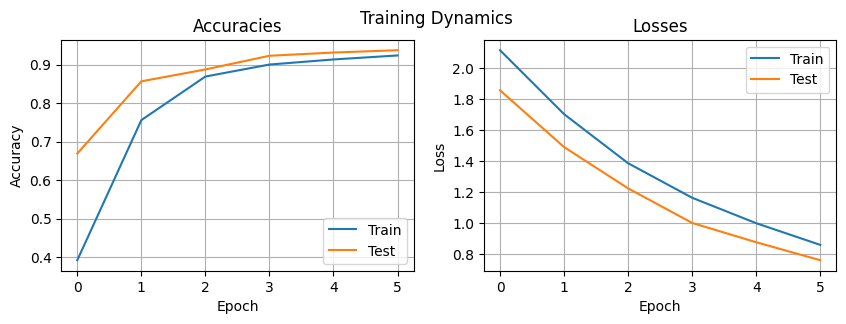

In [133]:
plot_dynamics(train_losses, test_losses, train_accuracies, test_accuracies)

              precision    recall  f1-score   support

           0       0.98      0.94      0.96       249
           1       0.95      0.98      0.96       233
           2       0.99      0.95      0.97       278
           3       0.96      0.88      0.91       250
           4       0.88      0.90      0.89       240
           5       0.87      0.93      0.90       249
           6       0.92      0.88      0.90       251
           7       0.95      0.96      0.96       257
           8       0.94      0.99      0.96       241
           9       0.94      0.96      0.95       252

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



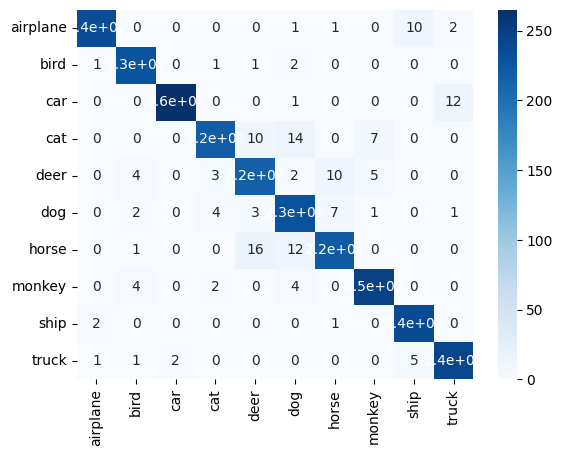

In [134]:
m = eval_model(test_loader, model, loss_fn, device)
display_metrics(m, classes)

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       251
           1       0.98      0.97      0.97       267
           2       1.00      0.95      0.97       222
           3       0.94      0.87      0.90       250
           4       0.88      0.94      0.91       260
           5       0.88      0.95      0.91       251
           6       0.96      0.88      0.91       249
           7       0.95      0.97      0.96       243
           8       0.90      0.98      0.94       259
           9       0.95      0.99      0.97       248

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



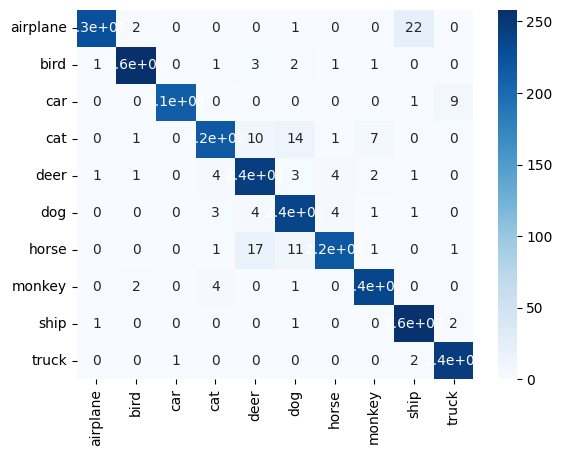

In [135]:
m = eval_model(train_loader, model, loss_fn, device)
display_metrics(m, classes)

In [136]:
PATH = params_dir / "resnet"
torch.save(model.fc.state_dict(), PATH)

### Model modification and Fine-Tuning (ViT)

We use the torch library implementation of ViT-B-16, with it's default transforms (ViT_B_16_Weights.IMAGENET1K_V1). documentation regarding the weights and its transforms can be found here https://docs.pytorch.org/vision/0.19/models/generated/torchvision.models.vit_b_16.html#torchvision.models.vit_b_16. 

In [137]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = vit_b_16(weights = ViT_B_16_Weights.IMAGENET1K_V1)
summary(model,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,)

Layer (type:depth-idx)                        Input Shape          Output Shape         Param #              Trainable
VisionTransformer                             [1, 3, 224, 224]     [1, 1000]            768                  True
├─Conv2d: 1-1                                 [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Encoder: 1-2                                [1, 197, 768]        [1, 197, 768]        151,296              True
│    └─Dropout: 2-1                           [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential: 2-2                        [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]        [1, 197, 768]        7,087,872            True
│    │    └─EncoderBlock: 3-3                 [1, 197, 768]        [1, 197, 768]     

In [138]:
for p in model.parameters():
    p.requires_grad = False

num_ft = model.heads.head.in_features
model.heads.head = torch.nn.Linear(num_ft, len(classes)).to(device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, weight_decay=1e-5)
num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
num_params

7690

In [139]:
epochs = 6
train_losses, test_losses, train_accuracies, test_accuracies=train(train_loader,
                        test_loader,epochs, optimizer,  model, loss_fn, device)

  0%|          | 0/6 [00:00<?, ?it/s]

epoch: 1

Train loss: 2.13248 |  Train acc: 29.40 %

Test loss: 1.90088 | Test acc: 50.96 %



 17%|█▋        | 1/6 [00:33<02:49, 33.87s/it]

epoch: 2

Train loss: 1.71821 |  Train acc: 63.72 %

Test loss: 1.54152 | Test acc: 75.20 %



 33%|███▎      | 2/6 [01:07<02:16, 34.01s/it]

epoch: 3

Train loss: 1.39302 |  Train acc: 80.40 %

Test loss: 1.26617 | Test acc: 85.48 %



 50%|█████     | 3/6 [01:42<01:42, 34.03s/it]

epoch: 4

Train loss: 1.15172 |  Train acc: 87.52 %

Test loss: 1.06065 | Test acc: 89.00 %



 67%|██████▋   | 4/6 [02:16<01:08, 34.03s/it]

epoch: 5

Train loss: 0.96987 |  Train acc: 90.88 %

Test loss: 0.90830 | Test acc: 91.28 %



 83%|████████▎ | 5/6 [02:50<00:34, 34.03s/it]

epoch: 6

Train loss: 0.84598 |  Train acc: 93.20 %

Test loss: 0.79300 | Test acc: 93.40 %



100%|██████████| 6/6 [03:24<00:00, 34.02s/it]


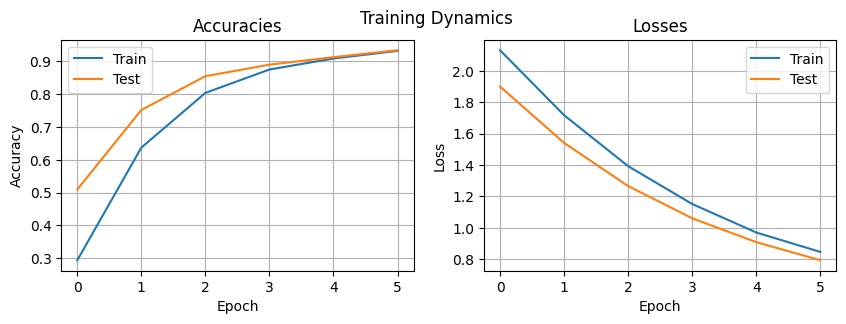

In [140]:
plot_dynamics(train_losses, test_losses, train_accuracies, test_accuracies)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       249
           1       0.91      0.91      0.91       233
           2       0.97      0.96      0.97       278
           3       0.94      0.93      0.93       250
           4       0.88      0.98      0.93       240
           5       0.94      0.76      0.84       249
           6       0.91      0.92      0.91       251
           7       0.93      0.98      0.95       257
           8       0.94      0.97      0.96       241
           9       0.95      0.96      0.96       252

    accuracy                           0.93      2500
   macro avg       0.93      0.93      0.93      2500
weighted avg       0.93      0.93      0.93      2500



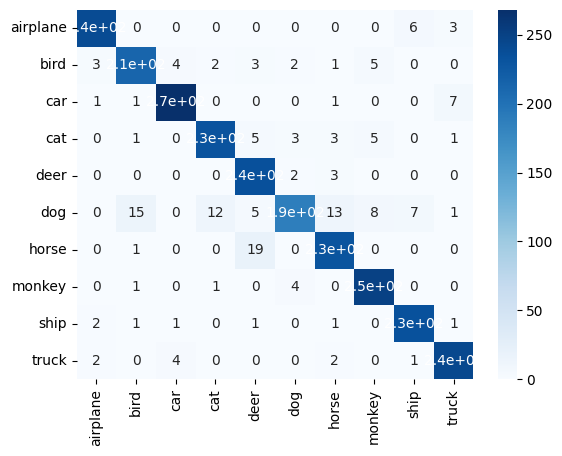

In [141]:
m = eval_model(test_loader, model, loss_fn, device)
display_metrics(m, classes)

              precision    recall  f1-score   support

           0       0.97      0.94      0.95       251
           1       0.96      0.90      0.93       267
           2       0.96      0.98      0.97       222
           3       0.94      0.95      0.94       250
           4       0.87      0.98      0.92       260
           5       0.97      0.82      0.89       251
           6       0.92      0.90      0.91       249
           7       0.94      0.99      0.96       243
           8       0.93      0.99      0.96       259
           9       0.96      0.98      0.97       248

    accuracy                           0.94      2500
   macro avg       0.94      0.94      0.94      2500
weighted avg       0.94      0.94      0.94      2500



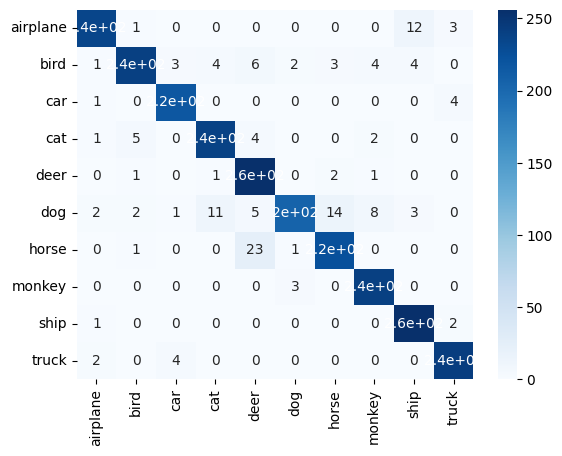

In [142]:
m = eval_model(train_loader, model, loss_fn, device)
display_metrics(m, classes)

In [146]:
PATH = params_dir / "vit"
torch.save(model.heads.head.state_dict(), PATH)

In [147]:
def load_resnet(path:str|pathlib.Path):
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
    num_ft = model.fc.in_features
    model.fc = torch.nn.Linear(num_ft, len(classes)).to(device)
    model.fc.load_state_dict(torch.load(path, weights_only=True))
    return model

def load_vit(path:str|pathlib.Path):
    model = vit_b_16(weights=ViT_B_16_Weights.IMAGENET1K_V1)
    num_ft = model.heads.head.in_features
    model.heads.head = torch.nn.Linear(num_ft, len(classes)).to(device)
    model.heads.head.load_state_dict(torch.load(path, weights_only=True))
    return model    


### Creating Transforms

Here we create the transforms that will be used for analysis. 